In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
from scipy.interpolate import RegularGridInterpolator


import pyrealsense2 as rs
import cv2
import torch

import time
from collections import deque


from force_control import z_force_control

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# Connect to robot

In [3]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")



# Connect to ultrasound image stream

In [4]:
ultrasoud_vid = cv2.VideoCapture('/dev/video8')

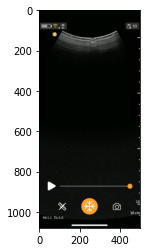

In [5]:

ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [6]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trunk_model = load_bunny_model('../../scripts/USImageCV/model_weights/trunk_seg_model.pth',device)
vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [7]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [8]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (142,83,45)
body_hsv_rad = (50,100,100)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [9]:
move_default_pose(rtde_c)

417 266


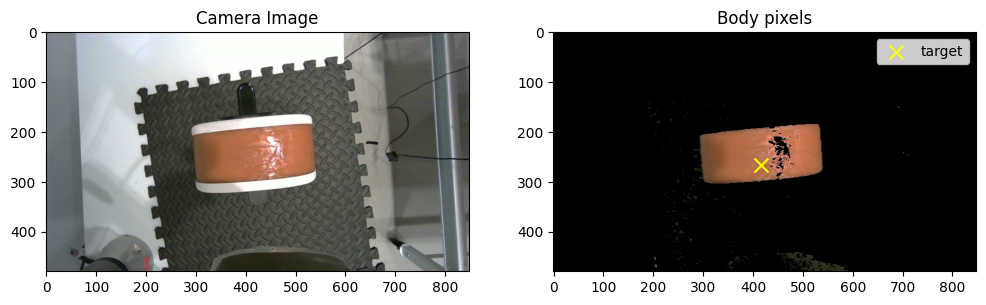

In [10]:

dist = sc.mainloop()
dist_threshold = 0.005
if dist<dist_threshold:
    print("Arrived at above target location. Start descending.")
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Utility functions

In [11]:

def interp3(x,y,z,img_org, xr,yr,zr):
    """resampling"""
    
    xi,yi,zi = np.meshgrid(xr, yr, zr, indexing='ij')
    min_val = np.min(img_org)

    interp = RegularGridInterpolator((x,y,z),img_org,bounds_error=False,fill_value=min_val)
    img = interp( (xi,yi,zi)).astype(np.float32)
    
    return img


def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz
   
def plot_slice(ploting_ax, img,slice,axis):
    '''
        Plot img along a specific axis.
    '''

    if axis==0:
        ploting_ax.imshow(img[slice])
    elif axis==1:
        ploting_ax.imshow(img[:,slice,:])
    elif axis==2:
        ploting_ax.imshow(img[:,:,slice])
    return ploting_ax

def plot_img_at(img, coord):
    '''
        Plot the 3D slicing view of img at coord.
    '''

    l,p,s = coord
    
    axis_label ={"L":"L: left to right",
                 "P":"P: front to back",
                 "S":"S: feet to head"}

    ax = plt.subplot(1, 3, 1)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["P"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    ax.imshow(np.squeeze(img[l,:,:]).T)
    ax.scatter(p,s,marker = 'x',s=30,label='Target location')
    ax.legend()

    ax = plt.subplot(1, 3, 2)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    
    ax.imshow(np.squeeze(img[:,p,:]).T)
    ax.scatter(l,s,marker = 'x',s=30)
    
    

    ax = plt.subplot(1, 3, 3)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["P"])
    ax.invert_yaxis()


    ax.imshow(np.squeeze(img[:,:,s]).T)
    ax.scatter(l,p,marker = 'x',s=30)
    
    
    return ax
def sitk2numpy(sitk_img):
    '''
        Return a numpy array that has the same shape as the sitk image.
    '''
    out = (sitk.GetArrayFromImage(sitk_img)).astype(np.float32)
    return out


In [12]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")

def y_direction_search(model):
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.03,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.03,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.001,
                        search_acc = 0.1)

def x_direction_search(model):
    # x direction search can be more crude, with intermediate speed vel=0.01
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.01,
                        search_acc = 0.1)

def bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                     search_vel=0.001,
                     search_acc=0.1):
    # Optimize the bunny view by traversing the robot from a start pose to a goal pose.

    # Move the TCP to the starting pose.
    rtde_c.moveL(start_pose,0.01,0.1) 
    
    # After reaching the starting pose, fire off the TCP to move towards the target_pose.
    # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
    rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
    
    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    area_diff = deque(maxlen=3)

    max_area = 0
    optim_pose = []
    frames = []
    for i in range(1000):
        linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
        speeds.append(linear_tcp_speed)
        
        ret, frame = ultrasoud_vid.read()	
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        ######


        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        # print("area",area,"Time elapsed:",time.time()-start_time)
        area_diff.append(area)
        
        if area>max_area:
            max_area = area
            optim_pose = curr_pose
        
        if len(area_diff)>=3 and\
             np.min(area_diff)>4000 and \
                area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
            # If the area starts to consistently decline, stop the robot. 
            # print(list(area_diff))
            rtde_c.stopL() 
            # We can call stopL() to manually stop the robot during execution.
            # This is very useful pairing with the async move of moveL.

            # And move the robot to the optimal pose
            rtde_c.moveL(optim_pose,0.01,0.1)

            return max_area,frames
        
        if linear_tcp_speed<1e-4:
            return max_area,frames
def find_object(detect_model,area_threshold=5000):
    '''
        detect_model: a neural network that detects the pixels of the object to find.
    '''
    max_a = 0
    while True:
        y_direction_search(detect_model)
        
        a,_ = x_direction_search(detect_model)
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=area_threshold:
            break


In [13]:

def centralize_object(model,pixel_distance_threshold=20):
    '''
        model: the neural network responsible for outputing the segmentation mask of the desired object.
    '''
    for i in range(20):
        ret, frame = ultrasoud_vid.read()	
        mask = bunny_mask_predict(model,frame,device)
        z_c,x_c=np.mean(np.argwhere(mask),axis=0)

        # We have ensured that the x axis of TCP aligns with axis 1 of frame, and z axis of TCP aligns with axis[0] of frame.
        x_dir = x_c-frame.shape[1]//2
        print("Centralizing the object. Pixel distance remaining: ",np.linalg.norm(x_dir))

        if np.linalg.norm(x_dir)<pixel_distance_threshold:
            break

        tcp_pose = rtde_r.getActualTCPPose()

        move_step = 1/100
        target_pose = rtde_c.poseTrans(tcp_pose,[move_step*np.sign(x_dir),0,0,0,0,0])


        rtde_c.moveL(target_pose,0.005,0.1)
    


In [14]:
def record_registration(record_model,n_samples):
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    
    # Move and record in the feet direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.03,0,0,0,0])
    f,p = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        record_model,device,
                        n_waypoints = n_samples//2)
    
    # Make sure the order is from feet towards head
    f.reverse()
    p.reverse()

    frames+=f
    poses+=p
    # Move and record in the head direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.03,0,0,0,0])
    f,p = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        record_model,device,
                        n_waypoints = n_samples//2)
    frames+=f
    poses+=p
    return frames,poses
def record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                    n_waypoints = 50):

    start_loc = start_pose[:3]
    target_loc = target_pose[:3]
    waypoints = np.linspace(start_loc,target_loc,n_waypoints)
    waypoints = [list(w)+start_pose[3:] for w in waypoints]

    rtde_c.moveL(start_pose,0.01,0.1)
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()
    start_pose = tcp_pose

    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    n_hist = 5
    areas = deque(maxlen=n_hist)

    poses=[]
    frames = []
    for w in waypoints:
        
        ret, frame = ultrasoud_vid.read()
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        poses.append(curr_pose)
        ######
        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        print("area",area,"Time elapsed:",time.time()-start_time)
        areas.append(area)
        if len(areas)>=n_hist and np.max(areas)<=2000:
            # If the area starts to consistently be small, stop the robot.
            # And move the robot to the start pose
            break
        rtde_c.moveL(w,0.01,0.1)
    rtde_c.moveL(start_pose,0.01,0.1)
    return frames,poses

In [15]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

target_force = 22
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

find_object(trunk_model)
centralize_object(trunk_model)

f,p = record_registration(vessel_model,n_samples=80)

Arrived at above target location. Start descending.
Contact made.


Current force is:22.131854647056194:  Time elapsed=00:13


Target force reached.
Max area 5845
Centralizing the object. Pixel distance remaining:  79.43273231622746
Centralizing the object. Pixel distance remaining:  19.84747200542924
area 5548 Time elapsed: 0.44270873069763184
area 5516 Time elapsed: 0.90911865234375
area 5456 Time elapsed: 1.5481276512145996
area 5277 Time elapsed: 2.164804697036743
area 5081 Time elapsed: 2.7394020557403564
area 4785 Time elapsed: 3.3640646934509277
area 4054 Time elapsed: 4.015812158584595
area 3714 Time elapsed: 4.649246454238892
area 3574 Time elapsed: 5.27625036239624
area 3131 Time elapsed: 5.858574390411377
area 3163 Time elapsed: 6.4976983070373535
area 2924 Time elapsed: 7.113917350769043
area 2896 Time elapsed: 7.7305519580841064
area 2448 Time elapsed: 8.330575227737427
area 2034 Time elapsed: 8.960976839065552
area 2326 Time elapsed: 9.583844423294067
area 2270 Time elapsed: 10.229247570037842
area 2334 Time elapsed: 10.874266147613525
area 2763 Time elapsed: 11.62942385673523
area 2731 Time elap

# 3D Registration

In [16]:
masks = []
for frame in f:
    masks.append(bunny_mask_predict(vessel_model,frame,device))
masks = np.array(masks)

# Get rid of the noisy predictions in the image. Only save the maximal connected component
_,masks = max_connected_area(masks,return_mask=True)

vessel_us = sitk.GetImageFromArray(masks)
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)
xspacing = sp['xspacing']
yspacing = sp['yspacing']
start_loc = np.array(p[0][:3])
end_loc = np.array(p[-1][:3])
zspacing = 1000*np.linalg.norm(start_loc-end_loc)/len(f)
vessel_us.SetSpacing((xspacing,yspacing,zspacing))

# Save checkpoint for registration
sitk.WriteImage(vessel_us,'vessel_us.nii.gz')


In [17]:
from tqdm import trange

In [18]:
def loc2pixel(loc,spacing):
    spacing = np.array(spacing)
    return np.array(loc/spacing).astype(int)
def pixel2loc(pixel,spacing):
    spacing = np.array(spacing)
    return pixel * spacing
## resampling reference size and resolution
vessel_us = sitk.ReadImage('vessel_us.nii.gz')

vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')
o = [True,False,False] # The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
vessel_ct = sitk.Flip(vessel_ct,o)

ref_dx, ref_dy, ref_dz = 1.0, 1.0, 1.0
ref_nx, ref_ny, ref_nz = 100, 100, 100 # Keep the grid size smaller than 250x250x250 for efficient computation

xr = (np.linspace(0, ref_nx-1, ref_nx) - (ref_nx-1)/2.0)*ref_dx
yr = (np.linspace(0, ref_ny-1, ref_ny) - (ref_ny-1)/2.0)*ref_dy
zr = (np.linspace(0, ref_nz-1, ref_nz) - (ref_nz-1)/2.0)*ref_dz
ct_shape = vessel_ct.GetSize()
ct_res = vessel_ct.GetSpacing()
us_shape = vessel_us.GetSize()
us_res = vessel_us.GetSpacing()

us_img_0 = (sitk.GetArrayFromImage(vessel_us)).astype(np.float32)
# z,y,x->x,y,z
us_img_0 = np.swapaxes(us_img_0,0,2)

tmp_ct_img = (sitk.GetArrayFromImage(vessel_ct)).astype(np.float32)
# z,y,x->x,y,z
tmp_ct_img = np.swapaxes(tmp_ct_img,0,2)

print("Resampling the 3D images")
## resampling ct and ultrasound images
x = (np.linspace(0, ct_shape[0]-1, ct_shape[0]) - (ct_shape[0]-1)/2.0)*ct_res[0]
y = (np.linspace(0, ct_shape[1]-1, ct_shape[1]) - (ct_shape[1]-1)/2.0)*ct_res[1]
z = (np.linspace(0, ct_shape[2]-1, ct_shape[2]) - (ct_shape[2]-1)/2.0)*ct_res[2]
img_ct = interp3(x, y, z, tmp_ct_img, xr, yr, zr)

###### The center pixel of us_img_0 is defined as the origin of the cartesian continuous coordinate frame ######
x = (np.linspace(0, us_shape[0]-1, us_shape[0]) - (us_shape[0]-1)/2.0)*us_res[0] 
y = (np.linspace(0, us_shape[1]-1, us_shape[1]) - (us_shape[1]-1)/2.0)*us_res[1]
z = (np.linspace(0, us_shape[2]-1, us_shape[2]) - (us_shape[2]-1)/2.0)*us_res[2]
us_img_1 = interp3(x, y, z, us_img_0, xr, yr, zr)
###### The center pixel of us_img_1 and has the same continuous coordinate as the center pixel of us_img_0. ######
# set the fixed image: CT
fixed_image = sitk.GetImageFromArray(img_ct.astype(np.float32)) 
fixed_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(fixed_image,'vessel_ct_resample.nii.gz')
# First, we calculate the centroid and move (=attach) ultrasound image to ct image

cx_us, cy_us, cz_us = np.round(centroid3(np.squeeze(us_img_1))).astype(np.int32)
cx_ct, cy_ct, cz_ct = np.round(centroid3(np.squeeze(img_ct))).astype(np.int32)
diff_x = cx_us-cx_ct
diff_y = cy_us-cy_ct
diff_z = cz_us-cz_ct
print("Coordinate difference:\t (diff_x, diff_y, diff_z) = (%d, %d, %d)"%(diff_x, diff_y, diff_z))
print("Resolution: \t\t (res_x, res_y, res_z) = (%.2f, %.2f, %.2f)"%(ref_dx,ref_dy,ref_dz))
# Usually vessel images are apart from each other. 
# Move the ultrasound image using centroid: now ultrasound and ct vessels are close, which is good for the rigid registration. 

img_us_move_centroid = interp3((xr-diff_x), (yr-diff_y), (zr-diff_z), us_img_1, xr, yr, zr)
moving_image = sitk.GetImageFromArray(img_us_move_centroid)
moving_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(moving_image,'vessel_us_resample.nii.gz')

## https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
num_iter = 20
print('Start optimizing the transformation')
for ii in trange(num_iter):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=20)
    registration_method.SetMetricSamplingStrategy(registration_method.REGULAR )
    registration_method.SetMetricSamplingPercentage(0.2)    
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=30, convergenceMinimumValue=1e-7, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Setup for the multi-resolution framework.            
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    # registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # Don't optimize in-place. We want to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    rigid_transform = registration_method.Execute(fixed_image, moving_image)

moving_reg = sitk.Resample(moving_image, fixed_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_reg,'vessel_reg.nii.gz')


Resampling the 3D images
Coordinate difference:	 (diff_x, diff_y, diff_z) = (-24, 24, -5)
Resolution: 		 (res_x, res_y, res_z) = (1.00, 1.00, 1.00)
Start optimizing the transformation


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


# Visualize registration result

In [19]:
img_ct_final = (sitk.GetArrayFromImage(fixed_image)).astype(np.float32)
img_us_final = (sitk.GetArrayFromImage(moving_reg)).astype(np.float32)



[67 13 66]


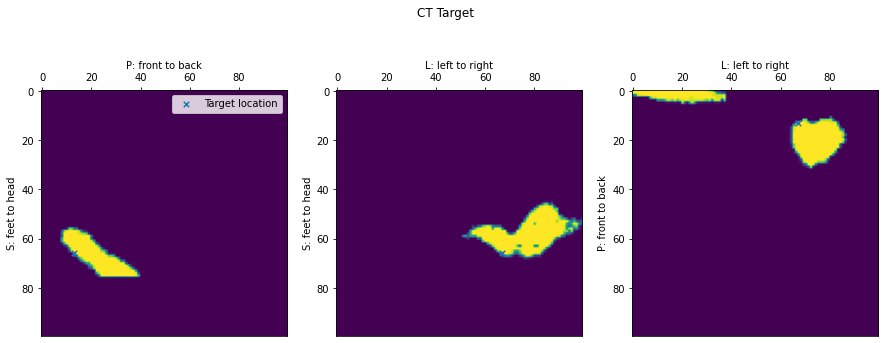

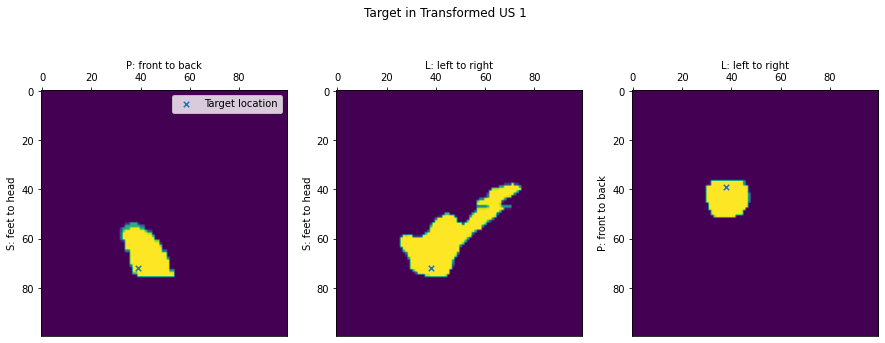

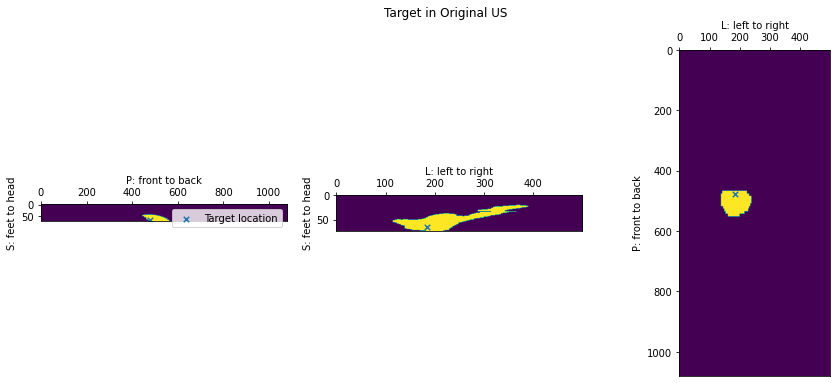

In [20]:

target_loc = centroid3(img_ct_final)+ np.array([0,0,6])
# target_loc = np.array(centroid3(img_ct_final))
target_pixel = loc2pixel(target_loc,fixed_image.GetSpacing())

print(target_pixel)
plt.figure(figsize=(15,6))
plot_img_at(img_ct_final,target_pixel)
plt.suptitle("CT Target")
plt.show()

inv = rigid_transform.GetInverse()
us_loc_1 = inv.TransformPoint(target_loc.astype(float))
us_loc_1 += np.array([diff_x,diff_y,diff_z])
us_pixel_1 = loc2pixel(us_loc_1,moving_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(us_img_1,us_pixel_1)
plt.suptitle("Target in Transformed US 1")
plt.show()


us_loc_0 = pixel2loc(us_pixel_1 - np.array(us_img_1.shape)/2,moving_image.GetSpacing())
us_pixel_0 = loc2pixel(us_loc_0,us_res)+np.array(us_img_0.shape)//2
plt.figure(figsize=(15,6))
plot_img_at(us_img_0,us_pixel_0)
plt.suptitle("Target in Original US")
plt.show()

[ 77  52 113]


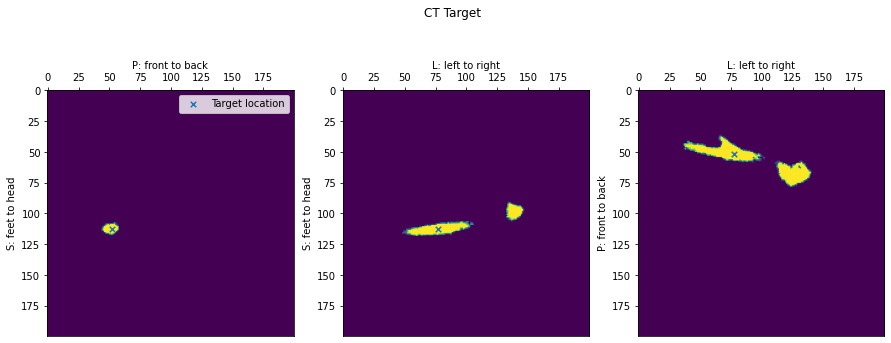

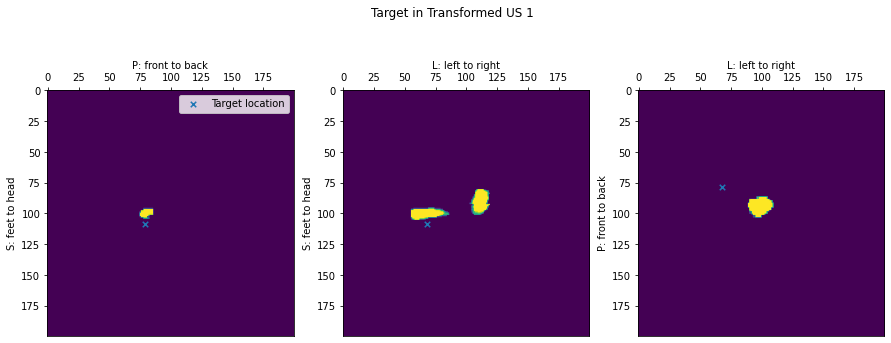

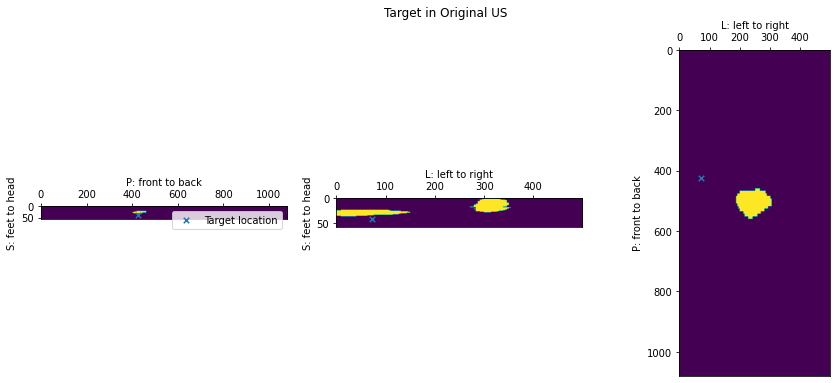

In [125]:

target_loc = centroid3(img_ct_final)+ np.array([-40,-10,6])
# target_loc = np.array(centroid3(img_ct_final))
target_pixel = loc2pixel(target_loc,fixed_image.GetSpacing())
print(target_pixel)
plt.figure(figsize=(15,6))
plot_img_at(img_ct_final,target_pixel)
plt.suptitle("CT Target")
plt.show()

inv = rigid_transform.GetInverse()
us_loc_1 = inv.TransformPoint(target_loc.astype(float))
us_loc_1 += np.array([diff_x,diff_y,diff_z])
us_pixel_1 = loc2pixel(us_loc_1,moving_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(us_img_1,us_pixel_1)
plt.suptitle("Target in Transformed US 1")
plt.show()


us_loc_0 = pixel2loc(us_pixel_1 - np.array(us_img_1.shape)/2,moving_image.GetSpacing())
us_pixel_0 = loc2pixel(us_loc_0,us_res)+np.array(us_img_0.shape)//2
plt.figure(figsize=(15,6))
plot_img_at(us_img_0,us_pixel_0)
plt.suptitle("Target in Original US")
plt.show()

In [15]:
pipeline.stop()

In [9]:
ultrasoud_vid.release()

# Clean up

In [37]:
ultrasoud_vid.release()
pipeline.stop()

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)